# Core Imports and Setup

In [1]:
import os
from pathlib import Path
from os import listdir
import numpy as np

import warnings
warnings.filterwarnings("ignore")

import logging
logging.getLogger("openff.toolkit").setLevel(logging.ERROR)

from openff import toolkit, evaluator

from openff.units import unit

from matplotlib import pyplot

import matplotlib.pyplot as plt

from scipy.stats import linregress,zscore

from sklearn.metrics import r2_score, mean_squared_error

# 1) - Loading ThermoML Data Sets

## Extracting data from ThermoML

In [2]:
from openff.evaluator.datasets import PhysicalProperty, PropertyPhase, PhysicalPropertyDataSet
from openff.evaluator.datasets.thermoml import thermoml_property, ThermoMLDataSet

data_set_initial = PhysicalPropertyDataSet.from_json("training-properties-with-water.json")
initial_df=data_set_initial.to_pandas()

In [3]:
initial_df.to_csv('data_set_initial.csv')

In [4]:
print(len(data_set_initial))
print(data_set_initial.property_types)
print(data_set_initial.substances)

123
{'EnthalpyOfMixing', 'Density'}
{<Substance CN(CCO)CCO{solv}{x=0.494100}|O{solv}{x=0.505900}>, <Substance CC(C)O{solv}{x=0.498100}|O{solv}{x=0.501900}>, <Substance CN(CCO)CCO{solv}{x=0.743000}|O{solv}{x=0.257000}>, <Substance NCCNCCN{solv}{x=0.501000}|O{solv}{x=0.499000}>, <Substance OCCNCCO{solv}{x=0.285600}|O{solv}{x=0.714400}>, <Substance NCCNCCO{solv}{x=0.399700}|O{solv}{x=0.600300}>, <Substance CC(C)O{solv}{x=0.704000}|O{solv}{x=0.296000}>, <Substance CCCOC(C)=O{solv}{x=0.831128}|O{solv}{x=0.168872}>, <Substance CN1CCNCC1{solv}{x=0.510900}|O{solv}{x=0.489100}>, <Substance OCCNCCO{solv}{x=0.700042}|O{solv}{x=0.299958}>, <Substance C1COCCN1{solv}{x=0.491100}|O{solv}{x=0.508900}>, <Substance NCCNCCO{solv}{x=0.069900}|O{solv}{x=0.930100}>, <Substance OCCN(CCO)CCO{solv}{x=0.107783}|O{solv}{x=0.892217}>, <Substance OCCN(CCO)CCO{solv}{x=0.206300}|O{solv}{x=0.793700}>, <Substance CC(C)O{solv}{x=0.231278}|O{solv}{x=0.768722}>, <Substance CNCCO{solv}{x=0.504100}|O{solv}{x=0.495900}>, <S

## Filtering data set

In [5]:
from rdkit import Chem
from rdkit.Chem import FilterCatalog
from openff.evaluator.substances import Component, Substance

In [6]:
subs=list(set(data_set_initial.substances))
smiles_list=[]

for i in subs:
    comps=[]
    comps.append(i.components[0].smiles)
    comps.append(i.components[1].smiles)
    for o in comps:
        comps.remove('O')
        [smiles_list.append(y) for y in comps]

print(len(smiles_list))

120


In [7]:
def get_func_smiles(smiles_list):
    mols_list=[]

    for s in smiles_list:
        m=Chem.MolFromSmiles(s)
        mols_list.append(m)

    alcohols=[]
    amines=[]
    both=[]
    other=[]
    
    fc = FilterCatalog.GetFunctionalGroupHierarchy()
    for i in range(len(mols_list)):
        whtv=mols_list[i]
        if not fc.GetMatches(whtv):
            other.append(i)
        else:
            for match in fc.GetMatches(whtv):
                ffg=match.GetDescription()
                # print(i,ffg)
                if ffg == 'Amine':
                    amines.append(i)
                elif ffg == 'Alcohol':
                    alcohols.append(i)
                if i in amines and i in alcohols:
                    both.append(i)
                    amines.remove(i)
                    alcohols.remove(i)
    

    def get_smiles(func_type):
        smiles=[]

        for x in func_type:
            comp0=subs[x].components[0].smiles
            comp1=subs[x].components[1].smiles
            if comp0 != 'O':
                smiles.append(comp0)
            if comp1 != 'O':
                smiles.append(comp1)
            # smiles.append(comp0) 
            # smiles.append(comp1)
        smiles.append('O')
        return smiles

    smiles_results={}

    smiles_results['all']=smiles_list
    smiles_results['alcohols']=get_smiles(alcohols)
    smiles_results['amines']=get_smiles(amines)
    smiles_results['both']=get_smiles(both)
    smiles_results['other']=get_smiles(other)

    return smiles_results

    

In [8]:
# et=mols_list[1]

# if match in fc.GetMatches(et):
#     for match in fc.GetMatches(et):
#         xyz=match.GetDescription()
#         print(xyz)
# else:
#     print("other")

In [9]:
smiles_results=get_func_smiles(smiles_list)

In [10]:
from openff.evaluator.datasets.curation.components.filtering import FilterByPropertyTypes, FilterByPropertyTypesSchema
from openff.evaluator.datasets.curation.components.filtering import FilterBySmiles, FilterBySmilesSchema

data_set_hmix_dens= FilterByPropertyTypes.apply(
    data_set_initial, FilterByPropertyTypesSchema(property_types=["EnthalpyOfMixing","Density"]))

print(len(data_set_hmix_dens))

data_set_alcohols= FilterBySmiles.apply(
    data_set_hmix_dens, FilterBySmilesSchema(smiles_to_include=smiles_results['alcohols']))

print(len(data_set_alcohols))

data_set_amines= FilterBySmiles.apply(
    data_set_hmix_dens, FilterBySmilesSchema(smiles_to_include=smiles_results['amines']))

print(len(data_set_amines))

data_set_both= FilterBySmiles.apply(
    data_set_hmix_dens, FilterBySmilesSchema(smiles_to_include=smiles_results['both']))

print(len(data_set_both))

data_set_other= FilterBySmiles.apply(
    data_set_hmix_dens, FilterBySmilesSchema(smiles_to_include=smiles_results['other']))

print(len(data_set_other))

123
18
33
62
10


### Inspecting and saving new properties

In [12]:
print(set(smiles_results['all']))

{'Cc1cccnc1', 'C1COCCN1', 'OCCN1CCOCC1', 'Cn1ccnc1', 'CN1CCCCC1', 'CCN(CC)CCO', 'NCCNCCO', 'OCCOCCO', 'OCCN(CCO)CCO', 'OCCNCCO', 'Cc1ccncc1', 'CN1CCNCC1', 'CNCCO', 'NCCNCCN', 'OC1=NCCC1', 'CN(C)CCO', 'OCC(O)CO', 'NCCCO', 'CN1CCOCC1', 'C1CCNCC1', 'CN(C)CCCO', 'NCCCNCCCN', 'CC(C)O', 'CN(CCO)CCO', 'CCCOC(C)=O'}


In [11]:
# save for future use

path=os.getcwd()

path_all=path+'/filtered_dataset_all.json'
data_set_hmix_dens.json(path_all, format=True)

path_alcohols = path+'/filtered_dataset_alcohols.json'
data_set_alcohols.json(path_alcohols, format=True)

path_amines = path+'/filtered_dataset_amines.json'
data_set_amines.json(path_amines, format=True)

path_both = path+'/filtered_dataset_both.json'
data_set_both.json(path_both, format=True)

path_other = path+'/filtered_dataset_other.json'
data_set_other.json(path_other, format=True)


# inspect new properties
pandas_all = data_set_hmix_dens.to_pandas()
pandas_alcohols = data_set_alcohols.to_pandas()
pandas_amines = data_set_amines.to_pandas()
pandas_both = data_set_both.to_pandas()
pandas_other = data_set_other.to_pandas()

## 3) Analysing Data Sets

### Plotting results all together

In [12]:
est_ds=PhysicalPropertyDataSet.from_json('TIP3P/estimated_dataset_hmix_dens.json')
estimated_df=est_ds.to_pandas()

In [13]:
def analysis_all(phys_prop,water_model,functional_group):
    
    experimental_data_set_path = ('filtered_dataset_%s.json'%functional_group)
    estimated_data_set_path = ('%s/estimated_dataset_hmix_dens.json'%water_model)

    experimental_data_set = PhysicalPropertyDataSet.from_json(experimental_data_set_path)
    estimated_data_set = PhysicalPropertyDataSet.from_json(estimated_data_set_path)

    properties_by_type = {phys_prop: []}

    preferred_units = {
        "Density": unit.kilogram / unit.meter**3,
        "EnthalpyOfMixing": unit.kilojoule / unit.mole,
    }

    for experimental_property in experimental_data_set:

        if (type(experimental_property).__qualname__) == phys_prop:
    #     # Find the estimated property which has the same id as the
    #     # experimental property.
            property_type = experimental_property.__class__.__name__
            estimated_property = next(
                x for x in estimated_data_set if x.id == experimental_property.id
            )
            # Add this pair of properties to the list of pairs
            properties_by_type[property_type].append((experimental_property, estimated_property))
    

    preferred_unit = preferred_units[property_type]
        
    experimental_values = []
    estimated_values = []
   
    
    for experimental_property, estimated_property in properties_by_type[property_type]:
        experimental_values.append(
            experimental_property.value.to(preferred_unit).magnitude
        )
        estimated_values.append(
            estimated_property.value.to(preferred_unit).magnitude
        )

    def results_stats(x,y):    
        slope, intercept, r_value, p_value, std_err = linregress(x, y)
        
        xarr=np.array(x)
        yarr=np.array(y)

        #outliers
        predictions=intercept+(slope*xarr)
        residuals=yarr-predictions
        zscores=np.abs(zscore(residuals))
        threshold=2.5
        outliers=np.where(zscores > threshold)[0]

        #uncertainties - bootstrapping
        def stats(xarr, yarr):
            r2 = r2_score(xarr, yarr)
            rmse = np.sqrt(mean_squared_error(xarr, yarr))
            return r2, rmse

        # Bootstrap function
        def bootstrap_mols(xarr, yarr, n_bootstraps=1000):
            r2_list = []
            rmse_list = []

            n_samples = len(xarr)
            for _ in range(n_bootstraps):
                ## Sampling molecule indices with replacement
                sample_indices = np.random.choice(n_samples, n_samples, replace=True)
                sample_true = np.array(xarr)[sample_indices]
                sample_pred = np.array(yarr)[sample_indices]
                
                ## Calculate R^2 and RMSE from taken sample
                r2, rmse = stats(sample_true, sample_pred)
                r2_list.append(r2)
                rmse_list.append(rmse)
            
            # Calculating error bounds
            r2_bounds = (np.percentile(r2_list, 2.5), np.percentile(r2_list, 97.5))
            rmse_bounds = (np.percentile(rmse_list, 2.5), np.percentile(rmse_list, 97.5))
            
            return r2_bounds, rmse_bounds
        
        r2,rmse=stats(xarr,yarr)
        r2_bounds, rmse_bounds = bootstrap_mols(experimental_values, estimated_values, n_bootstraps=1000)
        
        #results
        stats=dict()
        stats['slope']=slope
        stats['intercept']=intercept
        stats['r_value']=r_value
        stats['r2']=r2
        stats['r2_bounds']=r2_bounds
        stats['p_value']=p_value
        stats['std_err']=std_err
        stats['rmse']=rmse
        stats['rmse_bounds']=rmse_bounds
        stats['outliers']=outliers
        return stats

    results=dict()
    results["%s:%s-Experimental_Values" %(water_model,phys_prop)]=experimental_values
    results["%s:%s-Estimated_Values" %(water_model,phys_prop)]=estimated_values
    results["%s:%s-Stats" %(water_model,phys_prop)]=results_stats(experimental_values,estimated_values)
    
    return results

In [14]:
waters=('TIP3P','TIP3P_FB','TIP4P','TIP4P_FB','OPC','OPC3','GOPAL')

results_all=dict()
results_alcohols=dict()
results_amines=dict()
results_both=dict()
results_other=dict()

for w in waters:
    dens_result_all=analysis_all('Density', w, 'all')
    results_all.update(dens_result_all)
    hmix_result_all=analysis_all('EnthalpyOfMixing',w,'all')
    results_all.update(hmix_result_all)
    
    dens_result_alcohols=analysis_all('Density', w, 'alcohols')
    results_alcohols.update(dens_result_alcohols)
    hmix_result_alcohols=analysis_all('EnthalpyOfMixing',w,'alcohols')
    results_alcohols.update(hmix_result_alcohols)

    dens_result_amines=analysis_all('Density', w, 'amines')
    results_amines.update(dens_result_amines)
    hmix_result_amines=analysis_all('EnthalpyOfMixing',w,'amines')
    results_amines.update(hmix_result_amines)

    dens_result_both=analysis_all('Density', w, 'both')
    results_both.update(dens_result_both)
    hmix_result_both=analysis_all('EnthalpyOfMixing',w,'both')
    results_both.update(hmix_result_both)

    dens_result_other=analysis_all('Density', w, 'other')
    results_other.update(dens_result_other)



In [15]:
def plot_results(results, func):


    if func == 'other':
        plt.figure(figsize=(13.0, 6.0))
        plt.subplot(1,2,2)
        plt.axline(xy1=(0,0),slope=1,color='k')
        plt.plot(results['TIP3P:Density-Experimental_Values'], results['TIP3P:Density-Estimated_Values'], marker='x', linestyle='None', color='r',
                 label=r'$\bf{'+'TIP3P'+'}$ \n'+'$r^{2}$=%.3f (%.2f, %.2f) \n RMSE=%.3f (%.2f, %.2f)'%(results['TIP3P:Density-Stats']['r2'],results['TIP3P:Density-Stats']['r2_bounds'][0],results['TIP3P:Density-Stats']['r2_bounds'][1],
                                                                                results['TIP3P:Density-Stats']['rmse'],results['TIP3P:Density-Stats']['rmse_bounds'][0],results['TIP3P:Density-Stats']['rmse_bounds'][1]))
        # plt.axline(xy1=(0,results['TIP3P:Density-Stats']['intercept']),slope=results['TIP3P:Density-Stats']['slope'], linestyle="--", color='r', alpha=0.5, label='TIP3P $r^{2}$=%.3f, RMSE=%.3f'%(results['TIP3P:Density-Stats']['r2_value'], results['TIP3P:Density-Stats']['rmse']))
        plt.plot(results['TIP3P_FB:Density-Experimental_Values'], results['TIP3P_FB:Density-Estimated_Values'], marker='x', linestyle='None', color='b',
                 label=r'$\bf{'+'TIP3P\_FB'+'}$ \n'+'$r^{2}$=%.3f (%.2f, %.2f) \n RMSE=%.3f (%.2f, %.2f)'%(results['TIP3P_FB:Density-Stats']['r2'],results['TIP3P_FB:Density-Stats']['r2_bounds'][0],results['TIP3P_FB:Density-Stats']['r2_bounds'][1],
                                                                                results['TIP3P_FB:Density-Stats']['rmse'],results['TIP3P_FB:Density-Stats']['rmse_bounds'][0],results['TIP3P_FB:Density-Stats']['rmse_bounds'][1]))
        # plt.axline(xy1=(0,results['TIP3P_FB:Density-Stats']['intercept']),slope=results['TIP3P_FB:Density-Stats']['slope'], linestyle="--", color='b', alpha=0.5, label='TIP3P_FB $r^{2}$=%.3f, RMSE=%.3f'%(results['TIP3P_FB:Density-Stats']['r2_value'], results['TIP3P_FB:Density-Stats']['rmse']))
        plt.plot(results['TIP4P:Density-Experimental_Values'], results['TIP4P:Density-Estimated_Values'], marker='x', linestyle='None', color='g',
                 label=r'$\bf{'+'TIP4P'+'}$ \n'+'$r^{2}$=%.3f (%.2f, %.2f) \n RMSE=%.3f (%.2f, %.2f)'%(results['TIP4P:Density-Stats']['r2'],results['TIP4P:Density-Stats']['r2_bounds'][0],results['TIP4P:Density-Stats']['r2_bounds'][1],
                                                                                results['TIP4P:Density-Stats']['rmse'],results['TIP4P:Density-Stats']['rmse_bounds'][0],results['TIP4P:Density-Stats']['rmse_bounds'][1]))
        # plt.axline(xy1=(0,results['TIP4P:Density-Stats']['intercept']),slope=results['TIP4P:Density-Stats']['slope'], linestyle="--", color='g', alpha=0.5, label='TIP4P $r^{2}$=%.3f, RMSE=%.3f'%(results['TIP4P:Density-Stats']['r2_value'], results['TIP4P:Density-Stats']['rmse']))
        plt.plot(results['TIP4P_FB:Density-Experimental_Values'], results['TIP4P_FB:Density-Estimated_Values'], marker='x', linestyle='None', color='c',
                 label=r'$\bf{'+'TIP4P\_FB'+'}$ \n'+'$r^{2}$=%.3f (%.2f, %.2f) \n RMSE=%.3f (%.2f, %.2f)'%(results['TIP4P_FB:Density-Stats']['r2'],results['TIP4P_FB:Density-Stats']['r2_bounds'][0],results['TIP4P_FB:Density-Stats']['r2_bounds'][1],
                                                                                results['TIP4P_FB:Density-Stats']['rmse'],results['TIP4P_FB:Density-Stats']['rmse_bounds'][0],results['TIP4P_FB:Density-Stats']['rmse_bounds'][1]))
        # plt.axline(xy1=(0,results['TIP4P_FB:Density-Stats']['intercept']),slope=results['TIP4P_FB:Density-Stats']['slope'], linestyle="--", color='c', alpha=0.5, label='TIP4P_FB $r^{2}$=%.3f, RMSE=%.3f'%(results['TIP4P_FB:Density-Stats']['r2_value'], results['TIP4P_FB:Density-Stats']['rmse']))
        plt.plot(results['OPC:Density-Experimental_Values'], results['OPC:Density-Estimated_Values'], marker='x', linestyle='None', color='m',
                 label=r'$\bf{'+'OPC'+'}$ \n'+'$r^{2}$=%.3f (%.2f, %.2f) \n RMSE=%.3f (%.2f, %.2f)'%(results['OPC:Density-Stats']['r2'],results['OPC:Density-Stats']['r2_bounds'][0],results['OPC:Density-Stats']['r2_bounds'][1],
                                                                                results['OPC:Density-Stats']['rmse'],results['OPC:Density-Stats']['rmse_bounds'][0],results['OPC:Density-Stats']['rmse_bounds'][1]))
        # plt.axline(xy1=(0,results['OPC:Density-Stats']['intercept']),slope=results['OPC:Density-Stats']['slope'], linestyle="--", color='m', alpha=0.5, label='OPC $r^{2}$=%.3f, RMSE=%.3f'%(results['OPC:Density-Stats']['r2_value'], results['OPC:Density-Stats']['rmse']))
        plt.plot(results['OPC3:Density-Experimental_Values'], results['OPC3:Density-Estimated_Values'], marker='x', linestyle='None', color='darkorange',
                 label=r'$\bf{'+'OPC3'+'}$ \n'+'$r^{2}$=%.3f (%.2f, %.2f) \n RMSE=%.3f (%.2f, %.2f)'%(results['OPC3:Density-Stats']['r2'],results['OPC3:Density-Stats']['r2_bounds'][0],results['OPC3:Density-Stats']['r2_bounds'][1],
                                                                                results['OPC3:Density-Stats']['rmse'],results['OPC3:Density-Stats']['rmse_bounds'][0],results['OPC3:Density-Stats']['rmse_bounds'][1]))
        # plt.axline(xy1=(0,results['OPC3:Density-Stats']['intercept']),slope=results['OPC3:Density-Stats']['slope'], linestyle="--", color='darkorange', alpha=0.5, label='OPC3 $r^{2}$=%.3f, RMSE=%.3f'%(results['OPC3:Density-Stats']['r2_value'], results['OPC3:Density-Stats']['rmse']))
        plt.plot(results['GOPAL:Density-Experimental_Values'], results['GOPAL:Density-Estimated_Values'], marker='x', linestyle='None', color='indigo',
                 label=r'$\bf{'+'GOPAL'+'}$ \n'+'$r^{2}$=%.3f (%.2f, %.2f) \n RMSE=%.3f (%.2f, %.2f)'%(results['GOPAL:Density-Stats']['r2'],results['GOPAL:Density-Stats']['r2_bounds'][0],results['GOPAL:Density-Stats']['r2_bounds'][1],
                                                                                results['GOPAL:Density-Stats']['rmse'],results['GOPAL:Density-Stats']['rmse_bounds'][0],results['GOPAL:Density-Stats']['rmse_bounds'][1]))
        # plt.axline(xy1=(0,results['GOPAL:Density-Stats']['intercept']),slope=results['GOPAL:Density-Stats']['slope'], linestyle="--", color='indigo', alpha=0.5, label='GOPAL $r^{2}$=%.3f, RMSE=%.3f'%(results['GOPAL:Density-Stats']['r2_value'], results['GOPAL:Density-Stats']['rmse']))
        plt.xlim(800,1200)
        plt.ylim(800,1200)
        plt.title('Density $kg m^{-3}$- %s'%func)
        plt.xlabel('Experimental Value')
        plt.ylabel('OpenFF 2.1.0 Estimated Value')
        plt.legend(prop={'size': 6}, loc='lower right')

        plt.savefig('hmix_dens_plot_%s.png'%func)

        plt.show()

    else:
        plt.figure(figsize=(14.0, 6.0))
        plt.subplot(1,2,1)
        plt.axline(xy1=(0,0),slope=1,color='k')
        plt.plot(results['TIP3P:EnthalpyOfMixing-Experimental_Values'], results['TIP3P:EnthalpyOfMixing-Estimated_Values'], marker='x', linestyle='None', color='r', 
                label=r'$\bf{'+'TIP3P'+'}$ \n'+'$r^{2}$=%.3f (%.2f, %.2f) \n RMSE=%.3f (%.2f, %.2f)'%(results['TIP3P:EnthalpyOfMixing-Stats']['r2'],results['TIP3P:EnthalpyOfMixing-Stats']['r2_bounds'][0],results['TIP3P:EnthalpyOfMixing-Stats']['r2_bounds'][1],
                                                                                results['TIP3P:EnthalpyOfMixing-Stats']['rmse'],results['TIP3P:EnthalpyOfMixing-Stats']['rmse_bounds'][0],results['TIP3P:EnthalpyOfMixing-Stats']['rmse_bounds'][1]))
        # plt.axline(xy1=(0,results['TIP3P:EnthalpyOfMixing-Stats']['intercept']),slope=results['TIP3P:EnthalpyOfMixing-Stats']['slope'], linestyle="--", color='r', alpha=0.5, label='TIP3P $r^{2}$=%.3f, RMSE=%.3f'%(results['TIP3P:EnthalpyOfMixing-Stats']['r2_value'],results['TIP3P:EnthalpyOfMixing-Stats']['rmse']))
        plt.plot(results['TIP3P_FB:EnthalpyOfMixing-Experimental_Values'], results['TIP3P_FB:EnthalpyOfMixing-Estimated_Values'], marker='x', linestyle='None', color='b',
                 label=r'$\bf{'+'TIP3P\_FB'+'}$ \n'+'$r^{2}$=%.3f (%.2f, %.2f) \n RMSE=%.3f (%.2f, %.2f)'%(results['TIP3P_FB:EnthalpyOfMixing-Stats']['r2'],results['TIP3P_FB:EnthalpyOfMixing-Stats']['r2_bounds'][0],results['TIP3P_FB:EnthalpyOfMixing-Stats']['r2_bounds'][1],
                                                                                results['TIP3P_FB:EnthalpyOfMixing-Stats']['rmse'],results['TIP3P_FB:EnthalpyOfMixing-Stats']['rmse_bounds'][0],results['TIP3P_FB:EnthalpyOfMixing-Stats']['rmse_bounds'][1]))
        # plt.axline(xy1=(0,results['TIP3P_FB:EnthalpyOfMixing-Stats']['intercept']),slope=results['TIP3P_FB:EnthalpyOfMixing-Stats']['slope'], linestyle="--", color='b', alpha=0.5, label='TIP3P_FB $r^{2}$=%.3f, RMSE=%.3f'%(results['TIP3P_FB:EnthalpyOfMixing-Stats']['r2_value'], results['TIP3P_FB:EnthalpyOfMixing-Stats']['rmse']))
        plt.plot(results['TIP4P:EnthalpyOfMixing-Experimental_Values'], results['TIP4P:EnthalpyOfMixing-Estimated_Values'], marker='x', linestyle='None', color='g',
                 label=r'$\bf{'+'TIP4P'+'}$ \n'+'$r^{2}$=%.3f (%.2f, %.2f) \n RMSE=%.3f (%.2f, %.2f)'%(results['TIP4P:EnthalpyOfMixing-Stats']['r2'],results['TIP4P:EnthalpyOfMixing-Stats']['r2_bounds'][0],results['TIP4P:EnthalpyOfMixing-Stats']['r2_bounds'][1],
                                                                                results['TIP4P:EnthalpyOfMixing-Stats']['rmse'],results['TIP4P:EnthalpyOfMixing-Stats']['rmse_bounds'][0],results['TIP4P:EnthalpyOfMixing-Stats']['rmse_bounds'][1]))
        # plt.axline(xy1=(0,results['TIP4P:EnthalpyOfMixing-Stats']['intercept']),slope=results['TIP4P:EnthalpyOfMixing-Stats']['slope'], linestyle="--", color='g', alpha=0.5, label='TIP4P $r^{2}$=%.3f, RMSE=%.3f'%(results['TIP4P:EnthalpyOfMixing-Stats']['r2_value'],results['TIP4P:EnthalpyOfMixing-Stats']['rmse']))
        plt.plot(results['TIP4P_FB:EnthalpyOfMixing-Experimental_Values'], results['TIP4P_FB:EnthalpyOfMixing-Estimated_Values'], marker='x', linestyle='None', color='c',
                 label=r'$\bf{'+'TIP4P\_FB'+'}$ \n'+'$r^{2}$=%.3f (%.2f, %.2f) \n RMSE=%.3f (%.2f, %.2f)'%(results['TIP4P_FB:EnthalpyOfMixing-Stats']['r2'],results['TIP4P_FB:EnthalpyOfMixing-Stats']['r2_bounds'][0],results['TIP4P_FB:EnthalpyOfMixing-Stats']['r2_bounds'][1],
                                                                                results['TIP4P_FB:EnthalpyOfMixing-Stats']['rmse'],results['TIP4P_FB:EnthalpyOfMixing-Stats']['rmse_bounds'][0],results['TIP4P_FB:EnthalpyOfMixing-Stats']['rmse_bounds'][1]))
        # plt.axline(xy1=(0,results['TIP4P_FB:EnthalpyOfMixing-Stats']['intercept']),slope=results['TIP4P_FB:EnthalpyOfMixing-Stats']['slope'], linestyle="--", color='c', alpha=0.5, label='TIP4P_FB $r^{2}$=%.3f, RMSE=%.3f'%(results['TIP4P_FB:EnthalpyOfMixing-Stats']['r2_value'],results['TIP4P_FB:EnthalpyOfMixing-Stats']['rmse']))
        plt.plot(results['OPC:EnthalpyOfMixing-Experimental_Values'], results['OPC:EnthalpyOfMixing-Estimated_Values'], marker='x', linestyle='None', color='m',
                 label=r'$\bf{'+'OPC'+'}$ \n'+'$r^{2}$=%.3f (%.2f, %.2f) \n RMSE=%.3f (%.2f, %.2f)'%(results['OPC:EnthalpyOfMixing-Stats']['r2'],results['OPC:EnthalpyOfMixing-Stats']['r2_bounds'][0],results['OPC:EnthalpyOfMixing-Stats']['r2_bounds'][1],
                                                                                results['OPC:EnthalpyOfMixing-Stats']['rmse'],results['OPC:EnthalpyOfMixing-Stats']['rmse_bounds'][0],results['OPC:EnthalpyOfMixing-Stats']['rmse_bounds'][1]))
        # plt.axline(xy1=(0,results['OPC:EnthalpyOfMixing-Stats']['intercept']),slope=results['OPC:EnthalpyOfMixing-Stats']['slope'], linestyle="--", color='m', alpha=0.5, label='OPC $r^{2}$=%.3f, RMSE=%.3f'%(results['OPC:EnthalpyOfMixing-Stats']['r2_value'],results['OPC:EnthalpyOfMixing-Stats']['rmse']))
        plt.plot(results['OPC3:EnthalpyOfMixing-Experimental_Values'], results['OPC3:EnthalpyOfMixing-Estimated_Values'], marker='x', linestyle='None', color='darkorange', 
                 label=r'$\bf{'+'OPC3'+'}$ \n'+'$r^{2}$=%.3f (%.2f, %.2f) \n RMSE=%.3f (%.2f, %.2f)'%(results['OPC3:EnthalpyOfMixing-Stats']['r2'],results['OPC3:EnthalpyOfMixing-Stats']['r2_bounds'][0],results['OPC3:EnthalpyOfMixing-Stats']['r2_bounds'][1],
                                                                                results['OPC3:EnthalpyOfMixing-Stats']['rmse'],results['OPC3:EnthalpyOfMixing-Stats']['rmse_bounds'][0],results['OPC3:EnthalpyOfMixing-Stats']['rmse_bounds'][1]))
        # plt.axline(xy1=(0,results['OPC3:EnthalpyOfMixing-Stats']['intercept']),slope=results['OPC3:EnthalpyOfMixing-Stats']['slope'], linestyle="--", color='darkorange', alpha=0.5, label='OPC3 $r^{2}$=%.3f, RMSE=%.3f'%(results['OPC3:EnthalpyOfMixing-Stats']['r2_value'],results['OPC3:EnthalpyOfMixing-Stats']['rmse']))
        plt.plot(results['GOPAL:EnthalpyOfMixing-Experimental_Values'], results['GOPAL:EnthalpyOfMixing-Estimated_Values'], marker='x', linestyle='None', color='indigo',
                 label=r'$\bf{'+'GOPAL'+'}$ \n'+'$r^{2}$=%.3f (%.2f, %.2f) \n RMSE=%.3f (%.2f, %.2f)'%(results['GOPAL:EnthalpyOfMixing-Stats']['r2'],results['GOPAL:EnthalpyOfMixing-Stats']['r2_bounds'][0],results['GOPAL:EnthalpyOfMixing-Stats']['r2_bounds'][1],
                                                                                results['GOPAL:EnthalpyOfMixing-Stats']['rmse'],results['GOPAL:EnthalpyOfMixing-Stats']['rmse_bounds'][0],results['GOPAL:EnthalpyOfMixing-Stats']['rmse_bounds'][1]))
        # plt.axline(xy1=(0,results['GOPAL:EnthalpyOfMixing-Stats']['intercept']),slope=results['GOPAL:EnthalpyOfMixing-Stats']['slope'], linestyle="--", color='indigo', alpha=0.5, label='GOPAL $r^{2}$=%.3f, RMSE=%.3f'%(results['GOPAL:EnthalpyOfMixing-Stats']['r2_value'],results['GOPAL:EnthalpyOfMixing-Stats']['rmse']))
        plt.xlim(-5,2.7)
        plt.ylim(-5,2.7)
        plt.title('$H_{mix}$ $kJ mol^{-1}$ - %s'%func)
        plt.xlabel('Experimental Value')
        plt.ylabel('OpenFF 2.1.0 Estimated Value')
        plt.legend(prop={'size': 7}, loc='lower right')

        plt.subplot(1,2,2)
        plt.axline(xy1=(0,0),slope=1,color='k')
        plt.plot(results['TIP3P:Density-Experimental_Values'], results['TIP3P:Density-Estimated_Values'], marker='x', linestyle='None', color='r',
                 label=r'$\bf{'+'TIP3P'+'}$ \n'+'$r^{2}$=%.3f (%.2f, %.2f) \n RMSE=%.3f (%.2f, %.2f)'%(results['TIP3P:Density-Stats']['r2'],results['TIP3P:Density-Stats']['r2_bounds'][0],results['TIP3P:Density-Stats']['r2_bounds'][1],
                                                                                results['TIP3P:Density-Stats']['rmse'],results['TIP3P:Density-Stats']['rmse_bounds'][0],results['TIP3P:Density-Stats']['rmse_bounds'][1]))
        # plt.axline(xy1=(0,results['TIP3P:Density-Stats']['intercept']),slope=results['TIP3P:Density-Stats']['slope'], linestyle="--", color='r', alpha=0.5, label='TIP3P $r^{2}$=%.3f, RMSE=%.3f'%(results['TIP3P:Density-Stats']['r2_value'], results['TIP3P:Density-Stats']['rmse']))
        plt.plot(results['TIP3P_FB:Density-Experimental_Values'], results['TIP3P_FB:Density-Estimated_Values'], marker='x', linestyle='None', color='b',
                 label=r'$\bf{'+'TIP3P\_FB'+'}$ \n'+'$r^{2}$=%.3f (%.2f, %.2f) \n RMSE=%.3f (%.2f, %.2f)'%(results['TIP3P_FB:Density-Stats']['r2'],results['TIP3P_FB:Density-Stats']['r2_bounds'][0],results['TIP3P_FB:Density-Stats']['r2_bounds'][1],
                                                                                results['TIP3P_FB:Density-Stats']['rmse'],results['TIP3P_FB:Density-Stats']['rmse_bounds'][0],results['TIP3P_FB:Density-Stats']['rmse_bounds'][1]))
        # plt.axline(xy1=(0,results['TIP3P_FB:Density-Stats']['intercept']),slope=results['TIP3P_FB:Density-Stats']['slope'], linestyle="--", color='b', alpha=0.5, label='TIP3P_FB $r^{2}$=%.3f, RMSE=%.3f'%(results['TIP3P_FB:Density-Stats']['r2_value'], results['TIP3P_FB:Density-Stats']['rmse']))
        plt.plot(results['TIP4P:Density-Experimental_Values'], results['TIP4P:Density-Estimated_Values'], marker='x', linestyle='None', color='g',
                 label=r'$\bf{'+'TIP4P'+'}$ \n'+'$r^{2}$=%.3f (%.2f, %.2f) \n RMSE=%.3f (%.2f, %.2f)'%(results['TIP4P:Density-Stats']['r2'],results['TIP4P:Density-Stats']['r2_bounds'][0],results['TIP4P:Density-Stats']['r2_bounds'][1],
                                                                                results['TIP4P:Density-Stats']['rmse'],results['TIP4P:Density-Stats']['rmse_bounds'][0],results['TIP4P:Density-Stats']['rmse_bounds'][1]))
        # plt.axline(xy1=(0,results['TIP4P:Density-Stats']['intercept']),slope=results['TIP4P:Density-Stats']['slope'], linestyle="--", color='g', alpha=0.5, label='TIP4P $r^{2}$=%.3f, RMSE=%.3f'%(results['TIP4P:Density-Stats']['r2_value'], results['TIP4P:Density-Stats']['rmse']))
        plt.plot(results['TIP4P_FB:Density-Experimental_Values'], results['TIP4P_FB:Density-Estimated_Values'], marker='x', linestyle='None', color='c',
                 label=r'$\bf{'+'TIP4P\_FB'+'}$ \n'+'$r^{2}$=%.3f (%.2f, %.2f) \n RMSE=%.3f (%.2f, %.2f)'%(results['TIP4P_FB:Density-Stats']['r2'],results['TIP4P_FB:Density-Stats']['r2_bounds'][0],results['TIP4P_FB:Density-Stats']['r2_bounds'][1],
                                                                                results['TIP4P_FB:Density-Stats']['rmse'],results['TIP4P_FB:Density-Stats']['rmse_bounds'][0],results['TIP4P_FB:Density-Stats']['rmse_bounds'][1]))
        # plt.axline(xy1=(0,results['TIP4P_FB:Density-Stats']['intercept']),slope=results['TIP4P_FB:Density-Stats']['slope'], linestyle="--", color='c', alpha=0.5, label='TIP4P_FB $r^{2}$=%.3f, RMSE=%.3f'%(results['TIP4P_FB:Density-Stats']['r2_value'], results['TIP4P_FB:Density-Stats']['rmse']))
        plt.plot(results['OPC:Density-Experimental_Values'], results['OPC:Density-Estimated_Values'], marker='x', linestyle='None', color='m',
                 label=r'$\bf{'+'OPC'+'}$ \n'+'$r^{2}$=%.3f (%.2f, %.2f) \n RMSE=%.3f (%.2f, %.2f)'%(results['OPC:Density-Stats']['r2'],results['OPC:Density-Stats']['r2_bounds'][0],results['OPC:Density-Stats']['r2_bounds'][1],
                                                                                results['OPC:Density-Stats']['rmse'],results['OPC:Density-Stats']['rmse_bounds'][0],results['OPC:Density-Stats']['rmse_bounds'][1]))
        # plt.axline(xy1=(0,results['OPC:Density-Stats']['intercept']),slope=results['OPC:Density-Stats']['slope'], linestyle="--", color='m', alpha=0.5, label='OPC $r^{2}$=%.3f, RMSE=%.3f'%(results['OPC:Density-Stats']['r2_value'], results['OPC:Density-Stats']['rmse']))
        plt.plot(results['OPC3:Density-Experimental_Values'], results['OPC3:Density-Estimated_Values'], marker='x', linestyle='None', color='darkorange',
                 label=r'$\bf{'+'OPC3'+'}$ \n'+'$r^{2}$=%.3f (%.2f, %.2f) \n RMSE=%.3f (%.2f, %.2f)'%(results['OPC3:Density-Stats']['r2'],results['OPC3:Density-Stats']['r2_bounds'][0],results['OPC3:Density-Stats']['r2_bounds'][1],
                                                                                results['OPC3:Density-Stats']['rmse'],results['OPC3:Density-Stats']['rmse_bounds'][0],results['OPC3:Density-Stats']['rmse_bounds'][1]))
        # plt.axline(xy1=(0,results['OPC3:Density-Stats']['intercept']),slope=results['OPC3:Density-Stats']['slope'], linestyle="--", color='darkorange', alpha=0.5, label='OPC3 $r^{2}$=%.3f, RMSE=%.3f'%(results['OPC3:Density-Stats']['r2_value'], results['OPC3:Density-Stats']['rmse']))
        plt.plot(results['GOPAL:Density-Experimental_Values'], results['GOPAL:Density-Estimated_Values'], marker='x', linestyle='None', color='indigo',
                 label=r'$\bf{'+'GOPAL'+'}$ \n'+'$r^{2}$=%.3f (%.2f, %.2f) \n RMSE=%.3f (%.2f, %.2f)'%(results['GOPAL:Density-Stats']['r2'],results['GOPAL:Density-Stats']['r2_bounds'][0],results['GOPAL:Density-Stats']['r2_bounds'][1],
                                                                                results['GOPAL:Density-Stats']['rmse'],results['GOPAL:Density-Stats']['rmse_bounds'][0],results['GOPAL:Density-Stats']['rmse_bounds'][1]))
        # plt.axline(xy1=(0,results['GOPAL:Density-Stats']['intercept']),slope=results['GOPAL:Density-Stats']['slope'], linestyle="--", color='indigo', alpha=0.5, label='GOPAL $r^{2}$=%.3f, RMSE=%.3f'%(results['GOPAL:Density-Stats']['r2_value'], results['GOPAL:Density-Stats']['rmse']))
        plt.xlim(780,1300)
        plt.ylim(780,1300)
        plt.title('Density $kg m^{-3}$- %s'%func)
        plt.xlabel('Experimental Value')
        plt.ylabel('OpenFF 2.1.0 Estimated Value')
        plt.legend(prop={'size': 7}, loc='lower right')

        plt.savefig('hmix_dens_fig_%s.png'%func)

        plt.show()

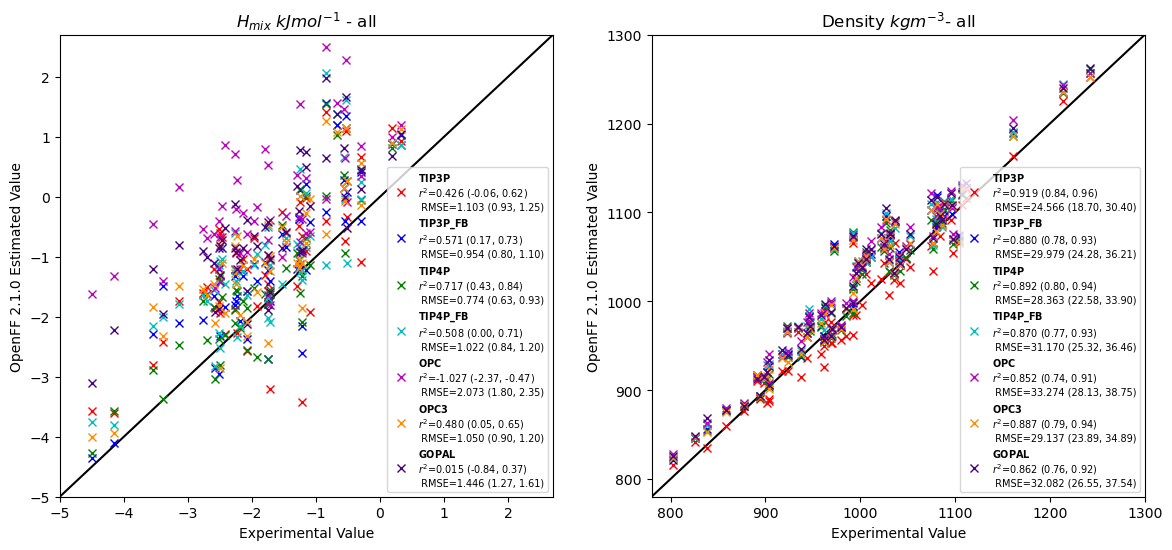

In [16]:
plot_results(results_all,'all')

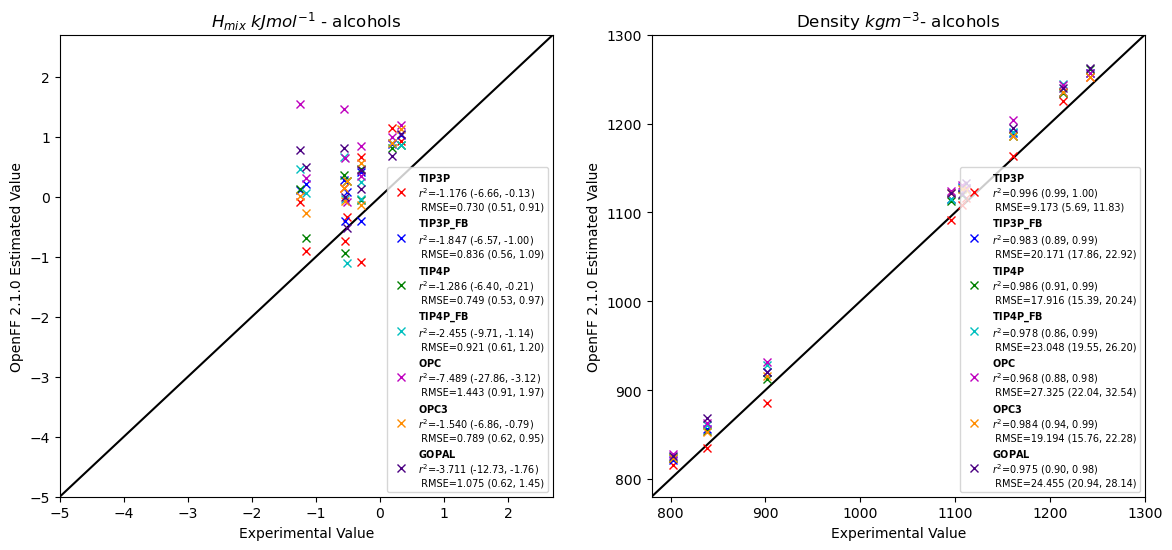

In [17]:
plot_results(results_alcohols,'alcohols')

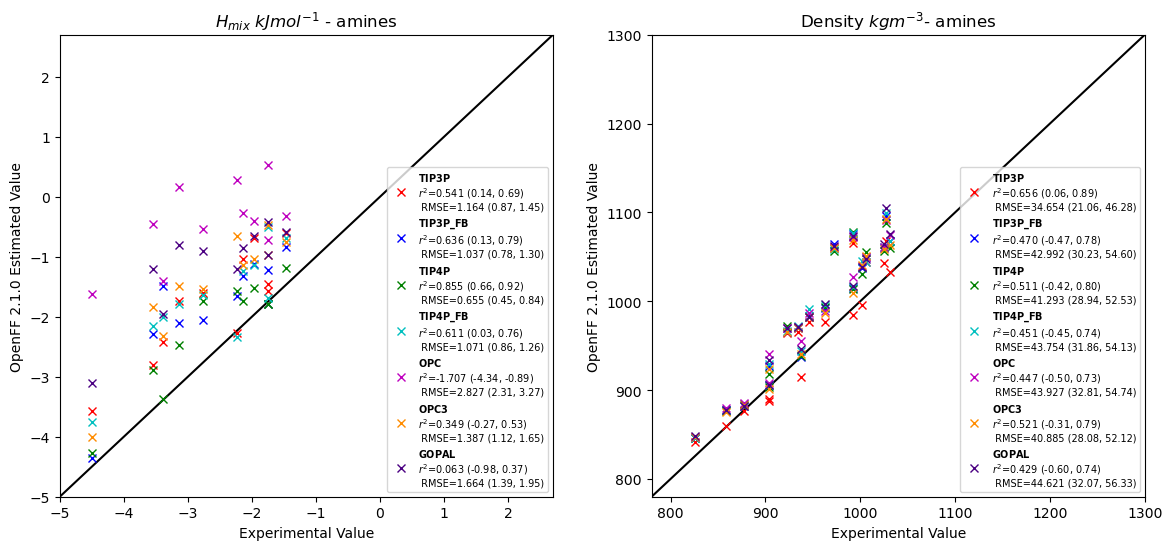

In [18]:
plot_results(results_amines,'amines')

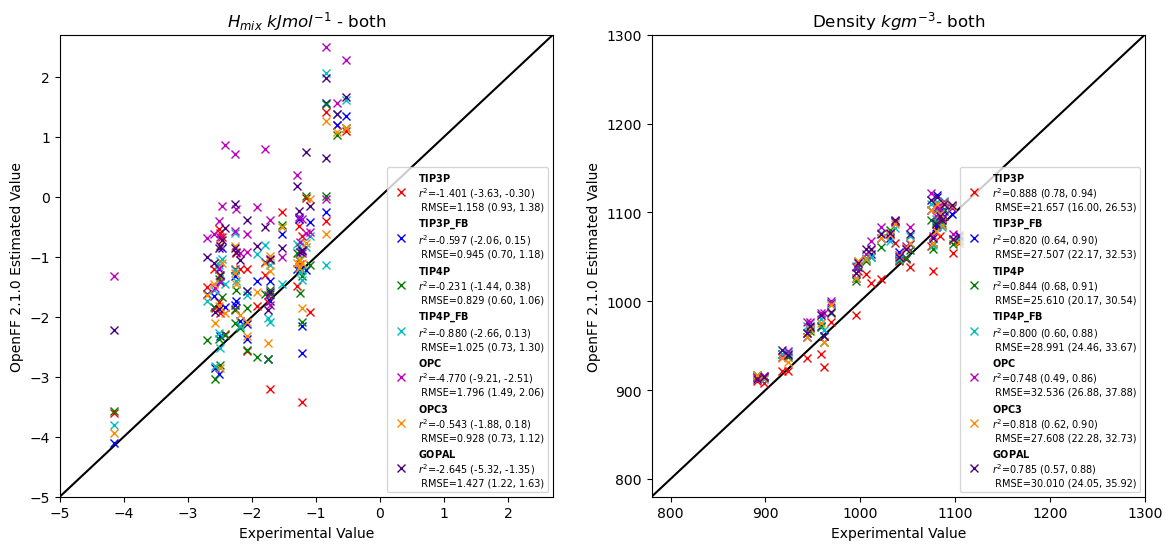

In [19]:
plot_results(results_both,'both')

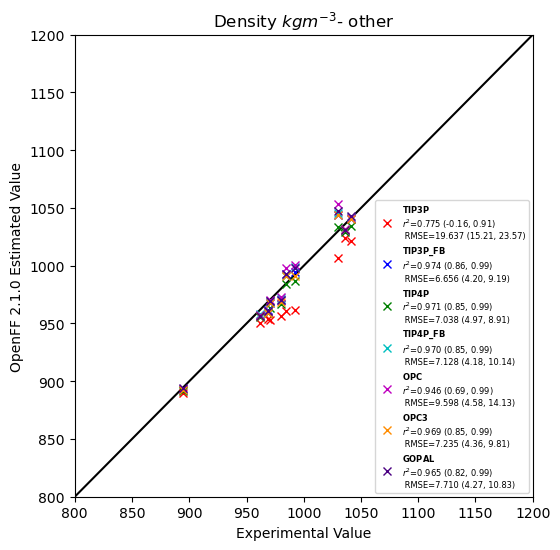

In [20]:
plot_results(results_other,'other')

## Info functional groups

In [21]:
filters = FilterCatalog.GetFlattenedFunctionalGroupHierarchy()
for k, pat in filters.items():
    print(f"{k} -> {Chem.MolToSmarts(pat)}")

AcidChloride -> C(=O)Cl
AcidChloride.Aliphatic -> [$(C-&!@[A&!Cl])](=O)Cl
AcidChloride.Aromatic -> [$(C-&!@a)](=O)Cl
Alcohol -> [O&H1&$(O-&!@[#6&!$(C=&!@[O,N,S])])]
Alcohol.Aliphatic -> [O&H1&$(O-&!@[C&!$(C=&!@[O,N,S])])]
Alcohol.Aromatic -> [O&H1&$(O-&!@c)]
Aldehyde -> [C&H1&D2&!$(C-[!#6&!#1])]=O
Aldehyde.Aliphatic -> [C&H1&D2&$(C-&!@C)]=O
Aldehyde.Aromatic -> [C&H1&D2&$(C-&!@a)]=O
Amine -> [N&$(N-[#6])&!$(N-[!#6&!#1])&!$(N-C=[O,N,S])]
Amine.Aliphatic -> [N&!$(N-c)&$(N-C)&!$(N-[!#6&!#1])&!$(N-C=[O,N,S])]
Amine.Aromatic -> [N&$(N-c)&!$(N-[!#6&!#1])&!$(N-C=[O,N,S])]
Amine.Cyclic -> [N&R&$(N-[#6])&!$(N-[!#6&!#1])&!$(N-C=[O,N,S])]
Amine.Primary -> [N&H2&D1&$(N-&!@[#6])&!$(N-C=[O,N,S])]
Amine.Primary.Aliphatic -> [N&H2&D1&$(N-&!@C)&!$(N-C=[O,N,S])]
Amine.Primary.Aromatic -> [N&H2&D1&$(N-&!@c)&!$(N-C=[O,N,S])]
Amine.Secondary -> [N&H1&D2&$(N(-[#6])-[#6])&!$(N-C=[O,N,S])]
Amine.Secondary.Aliphatic -> [N&H1&D2&$(N(-C)-C)&!$(N-C=[O,N,S])]
Amine.Secondary.Aromatic -> [N&H1&D2&$(N(-c)-[#6])&!$(N

In [22]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw, MolFromSmiles
from rdkit.Chem.Draw import MolsToGridImage, rdMolDraw2D, MolsMatrixToGridImage
import pubchempy
from PIL import Image, ImageDraw, ImageFont
IPythonConsole.ipython_useSVG=False  #< set this to False if you want PNGs instead of SVGs

In [23]:
import pandas as pd

In [24]:
other_df=pd.DataFrame(set(smiles_results['other']))

In [25]:
other_df

,0
0,O
1,Cn1ccnc1
2,CCCOC(C)=O
3,Cc1cccnc1
4,Cc1ccncc1


In [26]:
other_df['mol']=other_df[0].apply(lambda y: Chem.MolFromSmiles(y))

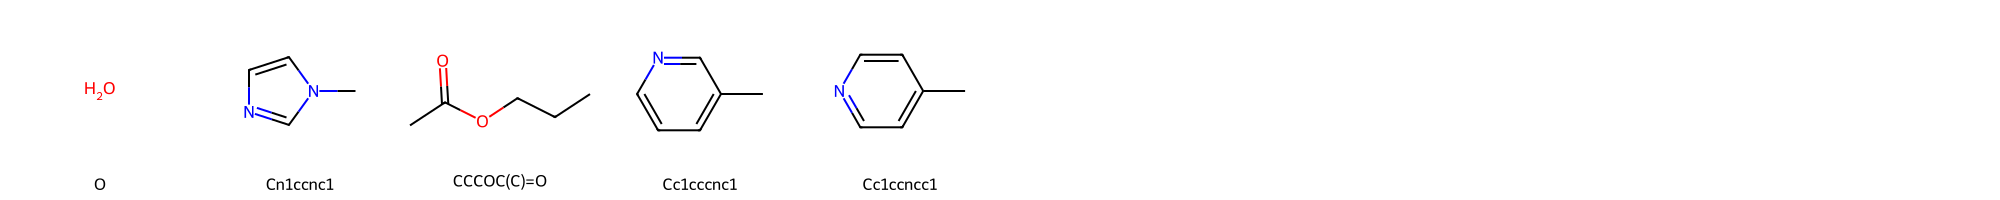

In [27]:
mol=other_df['mol'][:100]
Draw.MolsToGridImage(mol, molsPerRow=10, useSVG=True, legends=list(other_df[0][:100].values))

In [28]:
def get_figures(func_group):
    func_group_mols=[]
    matchlegend=[]
    for m in set(smiles_results[func_group]):
        if m != 'O':
            compounds=pubchempy.get_compounds(m, namespace='smiles')
            match = compounds[0]
            match_name=str(match.iupac_name)
            matchlegend.append(match_name)
            mol=Chem.MolFromSmiles(m)
            func_group_mols.append(mol)
    init_fig=MolsToGridImage(mols=func_group_mols, legends=matchlegend, molsPerRow=4, returnPNG=False)
    init_fig.save('%s_smiles.png'%func_group)
    ffig=Image.open('%s_smiles.png'%func_group)
    efig=ImageDraw.Draw(ffig)
    tfont=ImageFont.truetype("aileron_font/Aileron-Bold.otf", size=30)
    efig.text(xy=(10,8),text="%s"%func_group.upper(), font=tfont, align='center', fill=(255,0,0))
    ffig.save('%s_smiles.png'%func_group)
    return ffig


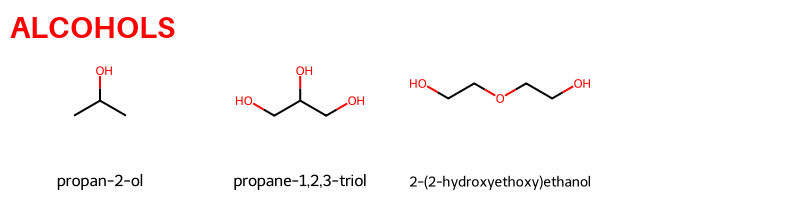

In [29]:
get_figures('alcohols')

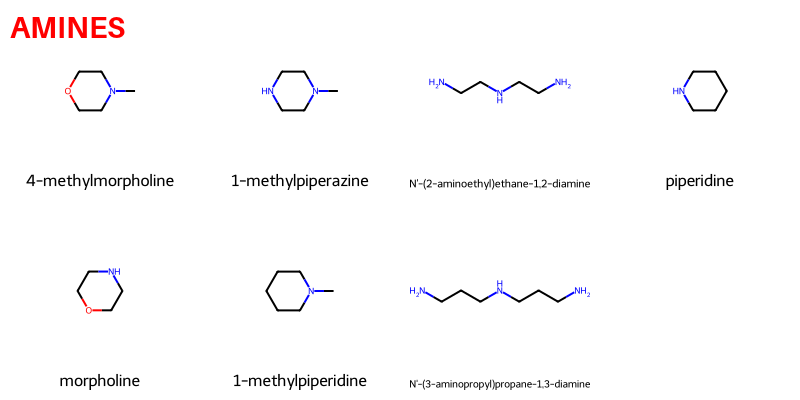

In [30]:
get_figures('amines')

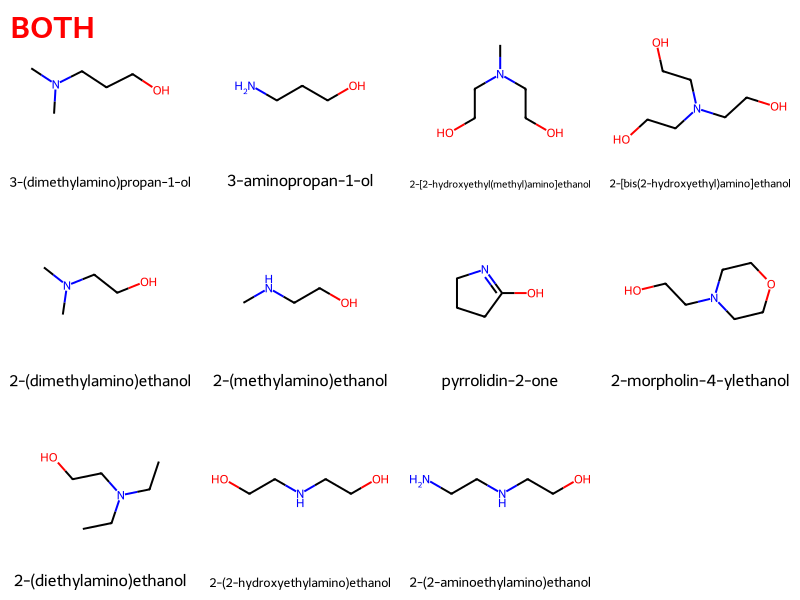

In [31]:
get_figures('both')

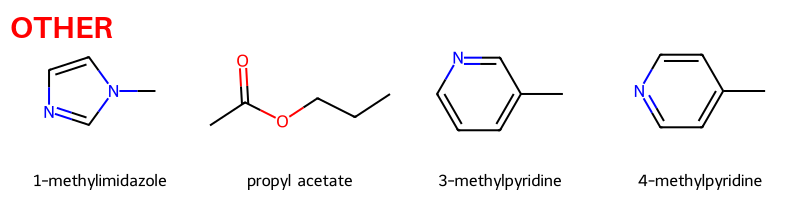

In [32]:
get_figures('other')

In [33]:
def stack_figs(list_im):
    imgs    = [ Image.open(i) for i in list_im ]

    # for a vertical stacking it is simple: use vstack
    imgs_comb = np.vstack([i for i in imgs])
    imgs_comb = Image.fromarray( imgs_comb)
    imgs_comb.save( 'groups_vertical.png' )
    return imgs_comb

In [35]:
# fig_list= ['alcohols.png','amines.png','both.png','other.png']
# stack_figs(fig_list)

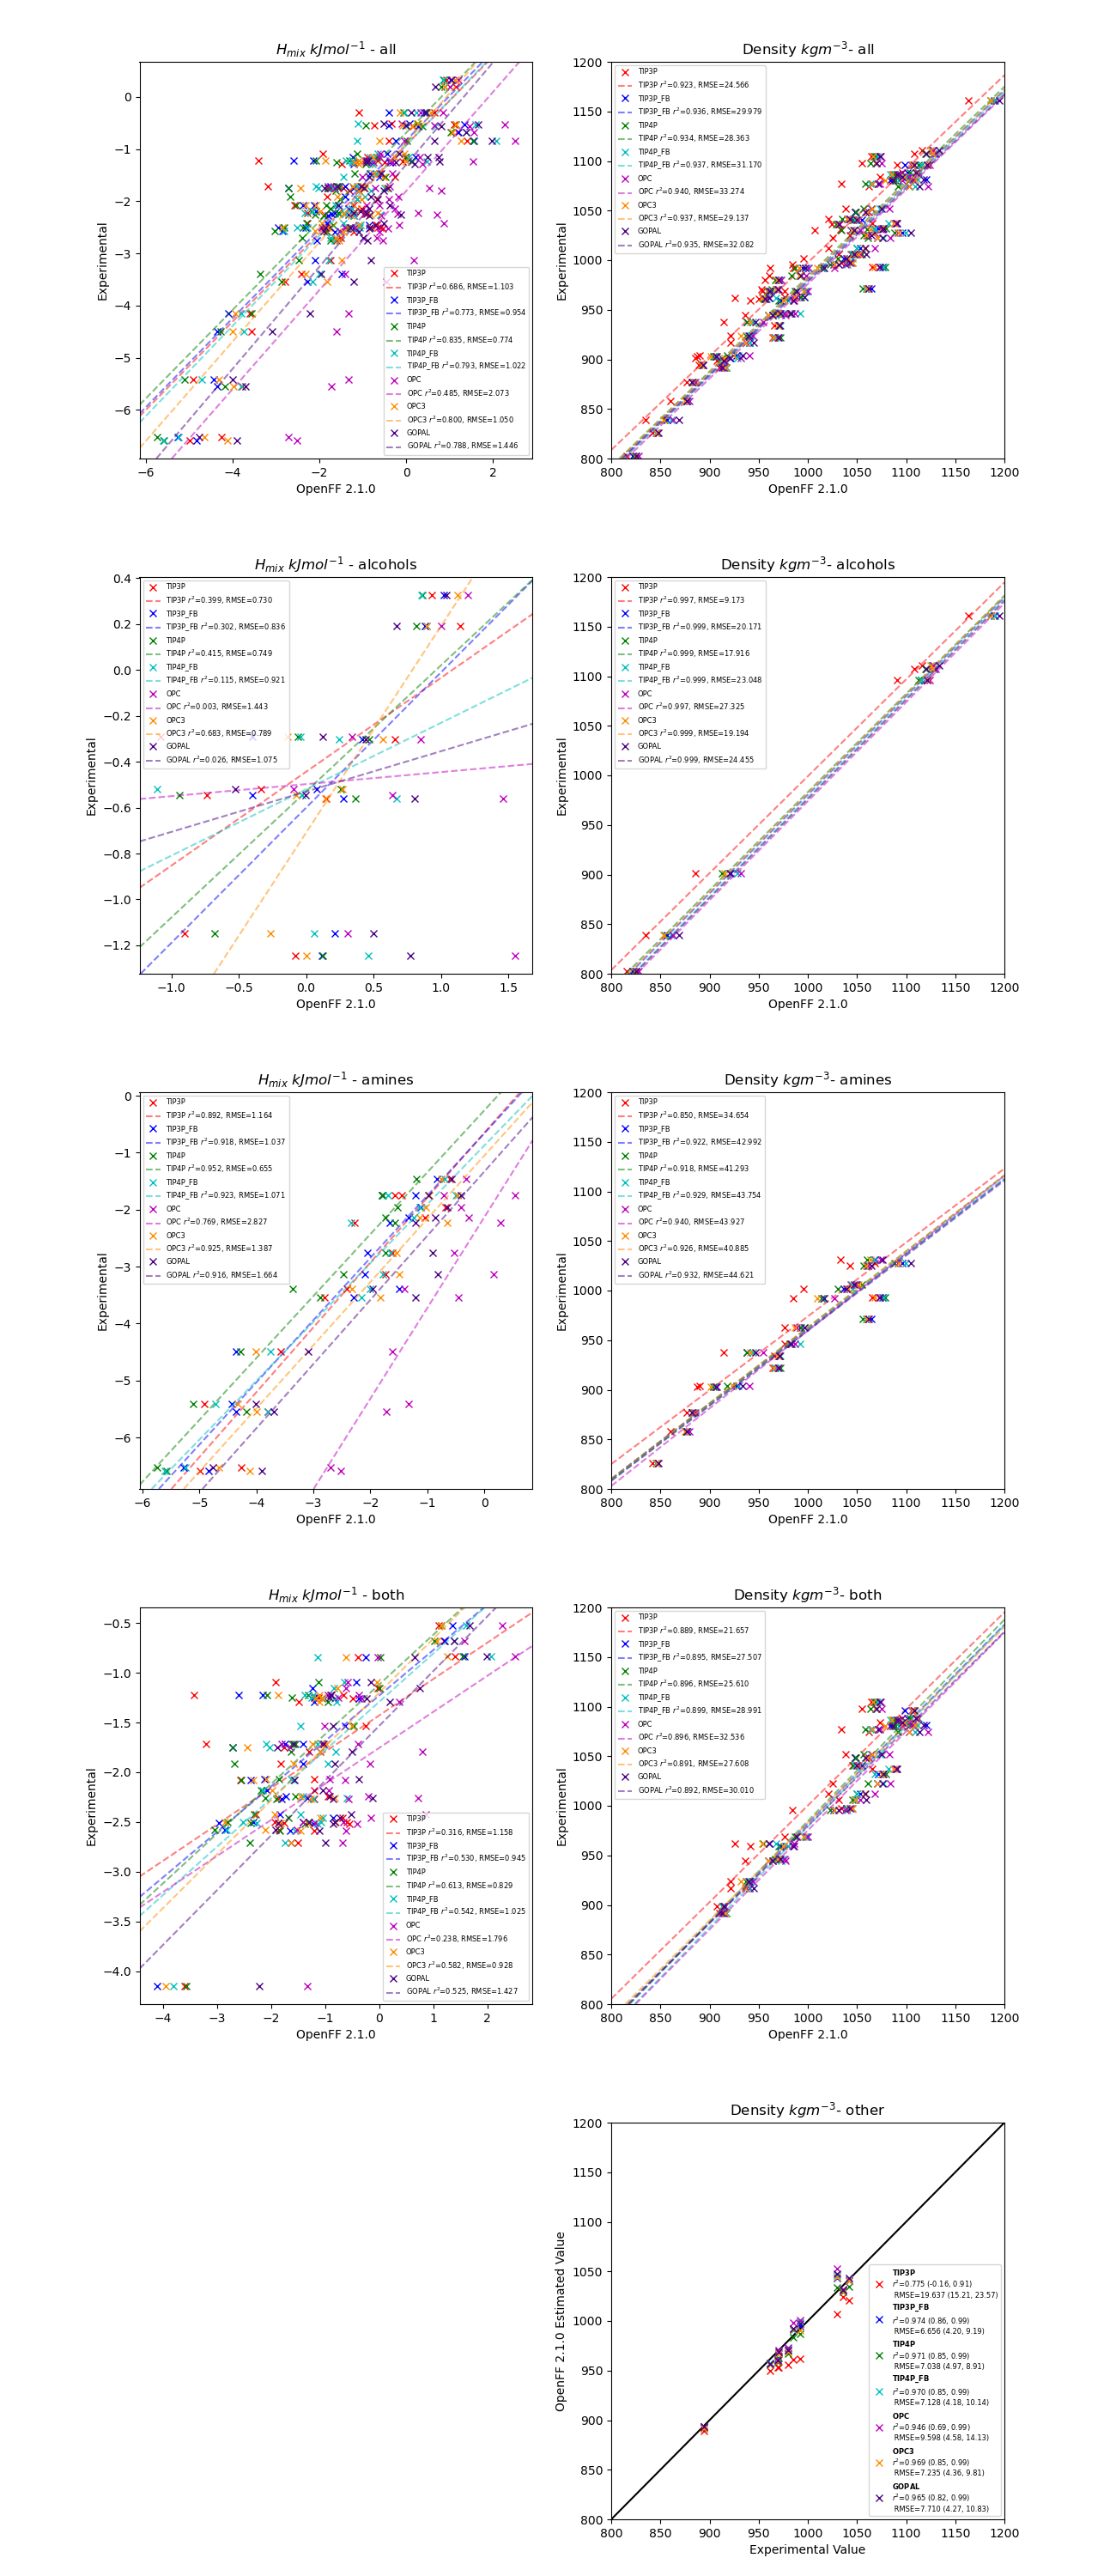

In [36]:
plot_list= ['hmix_dens_plot_all.png','hmix_dens_plot_alcohols.png','hmix_dens_plot_amines.png','hmix_dens_plot_both.png','hmix_dens_plot_other.png']
stack_figs(plot_list)

## RMSE

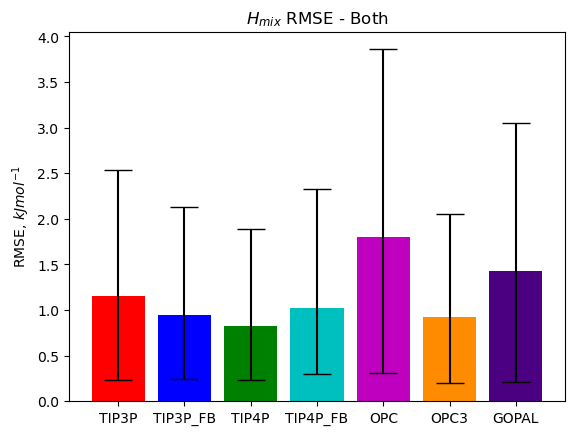

In [65]:
# Data
categories = ['TIP3P', 'TIP3P_FB', 'TIP4P', 'TIP4P_FB', 'OPC', 'OPC3', 'GOPAL']
rmse = [results_both['TIP3P:EnthalpyOfMixing-Stats']['rmse'],results_both['TIP3P_FB:EnthalpyOfMixing-Stats']['rmse'],results_both['TIP4P:EnthalpyOfMixing-Stats']['rmse'],results_both['TIP4P_FB:EnthalpyOfMixing-Stats']['rmse'],results_both['OPC:EnthalpyOfMixing-Stats']['rmse'],results_both['OPC3:EnthalpyOfMixing-Stats']['rmse'],results_both['GOPAL:EnthalpyOfMixing-Stats']['rmse']]
rmse_lower = [results_both['TIP3P:EnthalpyOfMixing-Stats']['rmse_bounds'][0],results_both['TIP3P_FB:EnthalpyOfMixing-Stats']['rmse_bounds'][0],results_both['TIP4P:EnthalpyOfMixing-Stats']['rmse_bounds'][0],results_both['TIP4P_FB:EnthalpyOfMixing-Stats']['rmse_bounds'][0],results_both['OPC:EnthalpyOfMixing-Stats']['rmse_bounds'][0],results_both['OPC3:EnthalpyOfMixing-Stats']['rmse_bounds'][0],results_both['GOPAL:EnthalpyOfMixing-Stats']['rmse_bounds'][0]]
rmse_upper = [results_both['TIP3P:EnthalpyOfMixing-Stats']['rmse_bounds'][1],results_both['TIP3P_FB:EnthalpyOfMixing-Stats']['rmse_bounds'][1],results_both['TIP4P:EnthalpyOfMixing-Stats']['rmse_bounds'][1],results_both['TIP4P_FB:EnthalpyOfMixing-Stats']['rmse_bounds'][1],results_both['OPC:EnthalpyOfMixing-Stats']['rmse_bounds'][1],results_both['OPC3:EnthalpyOfMixing-Stats']['rmse_bounds'][1],results_both['GOPAL:EnthalpyOfMixing-Stats']['rmse_bounds'][1]]

# Error bars (asymmetric)
error = [rmse_lower, rmse_upper]

# Plotting
fig, ax = plt.subplots()

# Create bar graph
bars = ax.bar(categories, rmse, yerr=error, capsize=10, color=['r', 'b', 'g', 'c', 'm', 'darkorange', 'indigo'])

# Labeling
ax.set_ylabel('RMSE, $kJ mol^{-1}$')
ax.set_title('$H_{mix}$ RMSE - Both')
# ax.set_ylim(0, 2)  # Adjust as needed for better visualization

# Save Plot
plt.savefig('hmix_rmse_both.png')

# Show the plot
plt.show()

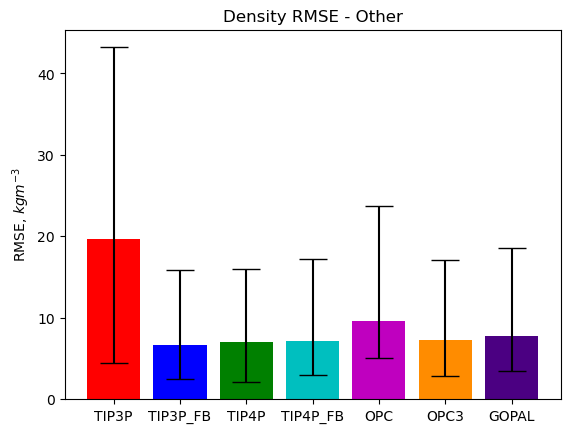

In [67]:
# Data
categories = ['TIP3P', 'TIP3P_FB', 'TIP4P', 'TIP4P_FB', 'OPC', 'OPC3', 'GOPAL']
rmse = [results_both['TIP3P:Density-Stats']['rmse'],results_both['TIP3P_FB:Density-Stats']['rmse'],results_both['TIP4P:Density-Stats']['rmse'],results_both['TIP4P_FB:Density-Stats']['rmse'],results_both['OPC:Density-Stats']['rmse'],results_both['OPC3:Density-Stats']['rmse'],results_both['GOPAL:Density-Stats']['rmse']]
rmse_lower = [results_both['TIP3P:Density-Stats']['rmse_bounds'][0],results_both['TIP3P_FB:Density-Stats']['rmse_bounds'][0],results_both['TIP4P:Density-Stats']['rmse_bounds'][0],results_both['TIP4P_FB:Density-Stats']['rmse_bounds'][0],results_both['OPC:Density-Stats']['rmse_bounds'][0],results_both['OPC3:Density-Stats']['rmse_bounds'][0],results_both['GOPAL:Density-Stats']['rmse_bounds'][0]]
rmse_upper = [results_both['TIP3P:Density-Stats']['rmse_bounds'][1],results_both['TIP3P_FB:Density-Stats']['rmse_bounds'][1],results_both['TIP4P:Density-Stats']['rmse_bounds'][1],results_both['TIP4P_FB:Density-Stats']['rmse_bounds'][1],results_both['OPC:Density-Stats']['rmse_bounds'][1],results_both['OPC3:Density-Stats']['rmse_bounds'][1],results_both['GOPAL:Density-Stats']['rmse_bounds'][1]]

# Error bars (asymmetric)
error = [rmse_lower, rmse_upper]

# Plotting
fig, ax = plt.subplots()

# Create bar graph
bars = ax.bar(categories, rmse, yerr=error, capsize=10, color=['r', 'b', 'g', 'c', 'm', 'darkorange', 'indigo'])

# Labeling
ax.set_ylabel('RMSE, $kg m^{-3}$')
ax.set_title('Density RMSE - Both')
# ax.set_ylim(0, 2)  # Adjust as needed for better visualization

# Save Plot
plt.savefig('dens_rmse_both.png')

# Show the plot
plt.show()

## Info Outliers

In [37]:
estimated_df.iloc[results_all['TIP3P_FB:EnthalpyOfMixing-Stats']['outliers']]

,Id,Temperature (K),Pressure (kPa),Phase,N Components,Component 1,Role 1,Mole Fraction 1,Exact Amount 1,Component 2,Role 2,Mole Fraction 2,Exact Amount 2,EnthalpyOfMixing Value (kJ / mol),EnthalpyOfMixing Uncertainty (kJ / mol),Density Value (g / ml),Density Uncertainty (g / ml),Source
16,6401,298.14,101.325,Liquid,2,CN(CCO)CCO,Solvent,0.2571,None,O,Solvent,0.7429,None,NaN,NaN,1.038564,0.000879,SimulationLayer
25,6410,298.15,101.000,Liquid,2,CNCCO,Solvent,0.1992,None,O,Solvent,0.8008,None,-0.944324,0.044185,NaN,NaN,SimulationLayer


In [38]:
def get_outliers(waters, result, func_group):
    outliers={}
    print('----------%s----------'%func_group)
    if func_group != 'other':
        for out in waters:
            outliers['%s-hmix_outliers-%s'%(out,func_group)]=[]
            print(out," - Hmix outliers:")
            hmix_ids=list(result['%s:EnthalpyOfMixing-Stats'%out]['outliers'])
            if hmix_ids == []:
                print('NONE')
            else:
                pass
            for h in hmix_ids:
                h=int(h)
                smi=estimated_df.at[h,'Component 1']
                if smi != 'O':
                    outliers['%s-hmix_outliers-%s'%(out,func_group)].append(smi)
                else:
                    smi=estimated_df.at[h,'Component 2']
                    outliers['%s-hmix_outliers-%s'%(out,func_group)].append(smi)
                print(h, smi)


            outliers['%s-density_outliers-%s'%(out,func_group)]=[]  
            print(out," - Density outliers:")
            dens_ids=list(result['%s:Density-Stats'%out]['outliers'])
            if dens_ids == []:
                print('NONE')
            else:
                pass
            for r in dens_ids:
                r=int(r)
                smi=estimated_df.at[r,'Component 1']
                if smi != 'O':
                    outliers['%s-density_outliers-%s'%(out,func_group)].append(smi)
                else:
                    smi=estimated_df.at[r,'Component 2']
                    outliers['%s-density_outliers-%s'%(out,func_group)].append(smi)
                print(r, smi)

        return outliers
    else:
        for out in waters:
            outliers['%s-density_outliers-%s'%(out,func_group)]=[]  
            print(out," - Density outliers:")
            dens_ids=list(result['%s:Density-Stats'%out]['outliers'])
            if dens_ids == []:
                print('NONE')
            else:
                pass
            for r in dens_ids:
                r=int(r)
                smi=estimated_df.at[r,'Component 1']
                if smi != 'O':
                    outliers['%s-density_outliers-%s'%(out,func_group)].append(smi)
                else:
                    smi=estimated_df.at[r,'Component 2']
                    outliers['%s-density_outliers-%s'%(out,func_group)].append(smi)
                print(r, smi)

        return outliers

In [39]:
outliers_all=get_outliers(waters,results_all,'all')
outliers_alcohols=get_outliers(waters,results_alcohols,'alcohols')
outliers_amines=get_outliers(waters,results_amines,'amines')
outliers_both=get_outliers(waters,results_both,'both')
outliers_other=get_outliers(waters,results_other,'other')

----------all----------
TIP3P  - Hmix outliers:
16 CN(CCO)CCO
34 OCCN(CCO)CCO
TIP3P  - Density outliers:
48 CC(C)O
49 CC(C)O
TIP3P_FB  - Hmix outliers:
16 CN(CCO)CCO
25 CNCCO
TIP3P_FB  - Density outliers:
48 CC(C)O
49 CC(C)O
TIP4P  - Hmix outliers:
25 CNCCO
TIP4P  - Density outliers:
48 CC(C)O
49 CC(C)O
TIP4P_FB  - Hmix outliers:
25 CNCCO
TIP4P_FB  - Density outliers:
48 CC(C)O
49 CC(C)O
OPC  - Hmix outliers:
25 CNCCO
OPC  - Density outliers:
48 CC(C)O
49 CC(C)O
OPC3  - Hmix outliers:
NONE
OPC3  - Density outliers:
26 CNCCO
48 CC(C)O
49 CC(C)O
GOPAL  - Hmix outliers:
25 CNCCO
GOPAL  - Density outliers:
48 CC(C)O
49 CC(C)O
----------alcohols----------
TIP3P  - Hmix outliers:
NONE
TIP3P  - Density outliers:
NONE
TIP3P_FB  - Hmix outliers:
NONE
TIP3P_FB  - Density outliers:
NONE
TIP4P  - Hmix outliers:
NONE
TIP4P  - Density outliers:
NONE
TIP4P_FB  - Hmix outliers:
NONE
TIP4P_FB  - Density outliers:
NONE
OPC  - Hmix outliers:
NONE
OPC  - Density outliers:
NONE
OPC3  - Hmix outliers:
NONE


In [40]:
outliers_both

{'TIP3P-hmix_outliers-both': ['CN(CCO)CCO'],
 'TIP3P-density_outliers-both': [],
 'TIP3P_FB-hmix_outliers-both': [],
 'TIP3P_FB-density_outliers-both': [],
 'TIP4P-hmix_outliers-both': [],
 'TIP4P-density_outliers-both': [],
 'TIP4P_FB-hmix_outliers-both': ['CN(CCO)CCO'],
 'TIP4P_FB-density_outliers-both': [],
 'OPC-hmix_outliers-both': [],
 'OPC-density_outliers-both': [],
 'OPC3-hmix_outliers-both': [],
 'OPC3-density_outliers-both': [],
 'GOPAL-hmix_outliers-both': [],
 'GOPAL-density_outliers-both': []}

In [41]:
def get_figures_outliers(water, smile_str, func_group, physprop):
    outliers_key = f'{water}-{physprop}_outliers-{func_group}'
    smiles_list = smile_str[outliers_key]
    
    func_group_mols = []
    match_legend = []
    num_mols=len(set(smiles_list))

    for smile in set(smiles_list):
        if smile != 'O' and smile != 'NONE':
            compounds = pubchempy.get_compounds(smile, namespace='smiles')
            match = compounds[0]
            match_legend.append(smile)
            mol = MolFromSmiles(smile)
            func_group_mols.append(mol)
        else:
            continue

    grid_image = MolsToGridImage(mols=func_group_mols, legends=match_legend, molsPerRow=num_mols, returnPNG=False)
    grid_image.save(f'outlier_figs/{func_group}/{physprop}/{water}_outliers.png')
    base_image = Image.open(f'outlier_figs/{func_group}/{physprop}/{water}_outliers.png')

    # Create new image with extra space for text
    new_height = base_image.height + 80
    new_image = Image.new("RGB", (base_image.width, new_height), "white")
    new_image.paste(base_image, (0, 50))

    # Add text to new image
    draw = ImageDraw.Draw(new_image)
    font = ImageFont.truetype("aileron_font/Aileron-Bold.otf", size=30)
    # draw.multiline_text((10, 8), f"{func_group.upper()}, {physprop} Outliers\n", font=font, fill=(255, 0, 0), spacing=20)
    # draw.line((10, 48, base_image.width - 10, 48), fill=(0, 0, 0))
    draw.multiline_text((10, 8), f"{water}\n", font=font, fill=(255, 155, 0), spacing=20)
    
    new_image.save(f'outlier_figs/{func_group}/{physprop}/{water}_outliers.png')
    return new_image

In [42]:
outliers_both

{'TIP3P-hmix_outliers-both': ['CN(CCO)CCO'],
 'TIP3P-density_outliers-both': [],
 'TIP3P_FB-hmix_outliers-both': [],
 'TIP3P_FB-density_outliers-both': [],
 'TIP4P-hmix_outliers-both': [],
 'TIP4P-density_outliers-both': [],
 'TIP4P_FB-hmix_outliers-both': ['CN(CCO)CCO'],
 'TIP4P_FB-density_outliers-both': [],
 'OPC-hmix_outliers-both': [],
 'OPC-density_outliers-both': [],
 'OPC3-hmix_outliers-both': [],
 'OPC3-density_outliers-both': [],
 'GOPAL-hmix_outliers-both': [],
 'GOPAL-density_outliers-both': []}

In [43]:
get_figures_outliers('OPC3',outliers_all,'all','hmix')

ZeroDivisionError: integer division or modulo by zero

In [44]:
current_path=os.path.abspath(os.getcwd())+'/outlier_figs/all/density/'
out_all_dens=listdir(current_path)

In [45]:
out_all_dens

['TIP4P_outliers.png',
 'TIP4P_FB_outliers.png',
 'TIP3P_outliers.png',
 'OPC_outliers.png',
 'GOPAL_outliers.png',
 'OPC3_outliers.png',
 'TIP3P_FB_outliers.png']

In [46]:
def create_image_with_title(image_paths, title, output_path):
    # Load the images
    images = [Image.open(path) for path in image_paths]
    
    # Get the maximum dimensions of the images
    max_width = max(img.width+134 for img in images)
    max_height = max(img.height for img in images)
    
    # Calculate the number of rows needed
    num_images = len(images)
    num_columns = 3
    num_rows = (num_images + num_columns - 1) // num_columns  # Each row has 4 images
    
    # Define the space needed for lines
    line_width = 2
    
    # Calculate the total width and height of the new image
    total_line_width = line_width * (num_columns - 1)
    total_row_line_height = line_width * (num_rows - 1)
    new_img_width = max_width * num_columns + total_line_width
    new_img_height = (max_height * num_rows) + total_row_line_height
    
    # Add height for the title
    title_font = ImageFont.truetype("aileron_font/Aileron-Bold.otf", size=36)
    title_height = title_font.getsize(title)[1] + 10  # Adding some padding
    new_img_height += title_height
    
    new_img = Image.new('RGB', (new_img_width, new_img_height), color=(255, 255, 255))
    
    # Draw the title
    draw = ImageDraw.Draw(new_img)
    text_width, text_height = draw.textsize(title, font=title_font)
    text_x = (new_img_width - text_width) // 2
    draw.text((text_x, 5), title, fill=(0, 0, 0), font=title_font)
    
    # Paste the images into the new image with vertical and horizontal lines between them
    y_offset = title_height
    for row in range(num_rows):
        x_offset = 0
        row_max_height = 0
        for col in range(num_columns):
            index = row * num_columns + col
            if index < num_images:
                img = images[index]
                
                # Calculate x offset to center the image
                centered_x_offset = x_offset + (max_width - img.width) // 2
                new_img.paste(img, (centered_x_offset, y_offset))
                
                row_max_height = max(row_max_height, img.height)
                
                x_offset += max_width
                
                # Draw a vertical line after each image except the last one in a row
                if col < num_columns - 1:
                    line_x = x_offset
                    draw.line([(line_x, y_offset), (line_x, y_offset + row_max_height)], fill=(0, 0, 0), width=line_width)
                    x_offset += line_width
        
        y_offset += row_max_height
        
        # Draw a horizontal line after each row except the last one
        if row < num_rows - 1:
            draw.line([(0, y_offset), (new_img_width, y_offset)], fill=(0, 0, 0), width=line_width)
            y_offset += line_width
    
    # Save the resulting image
    new_img.save(output_path)
    print(f"Image saved as {output_path}")

In [47]:
current_path=os.path.abspath(os.getcwd())+'/outlier_figs/both/hmix/'
out_all_dens=listdir(current_path)
image_paths = [current_path+x for x in out_all_dens]

title = "Outliers for Hmix in both"
output_path='outlier_figs/outliers_hmix_both.png'
create_image_with_title(image_paths, title, output_path)

Image saved as outlier_figs/outliers_hmix_both.png


In [48]:
def stack_figs_out(list_im):
    # Open images and convert to arrays
    imgs = [Image.open(i) for i in list_im]

    # Find the maximum width and sum of heights
    max_width = max(img.width for img in imgs)
    total_height = sum(img.height for img in imgs)

    # Create a new image with the calculated dimensions
    imgs_comb = Image.new('RGB', (max_width, total_height))

    # Paste images into the new image
    y_offset = 0
    for img in imgs:
        imgs_comb.paste(img, (0, y_offset))
        y_offset += img.height

    # Save the combined image
    imgs_comb.save('outliers_vertical.png')
    return imgs_comb

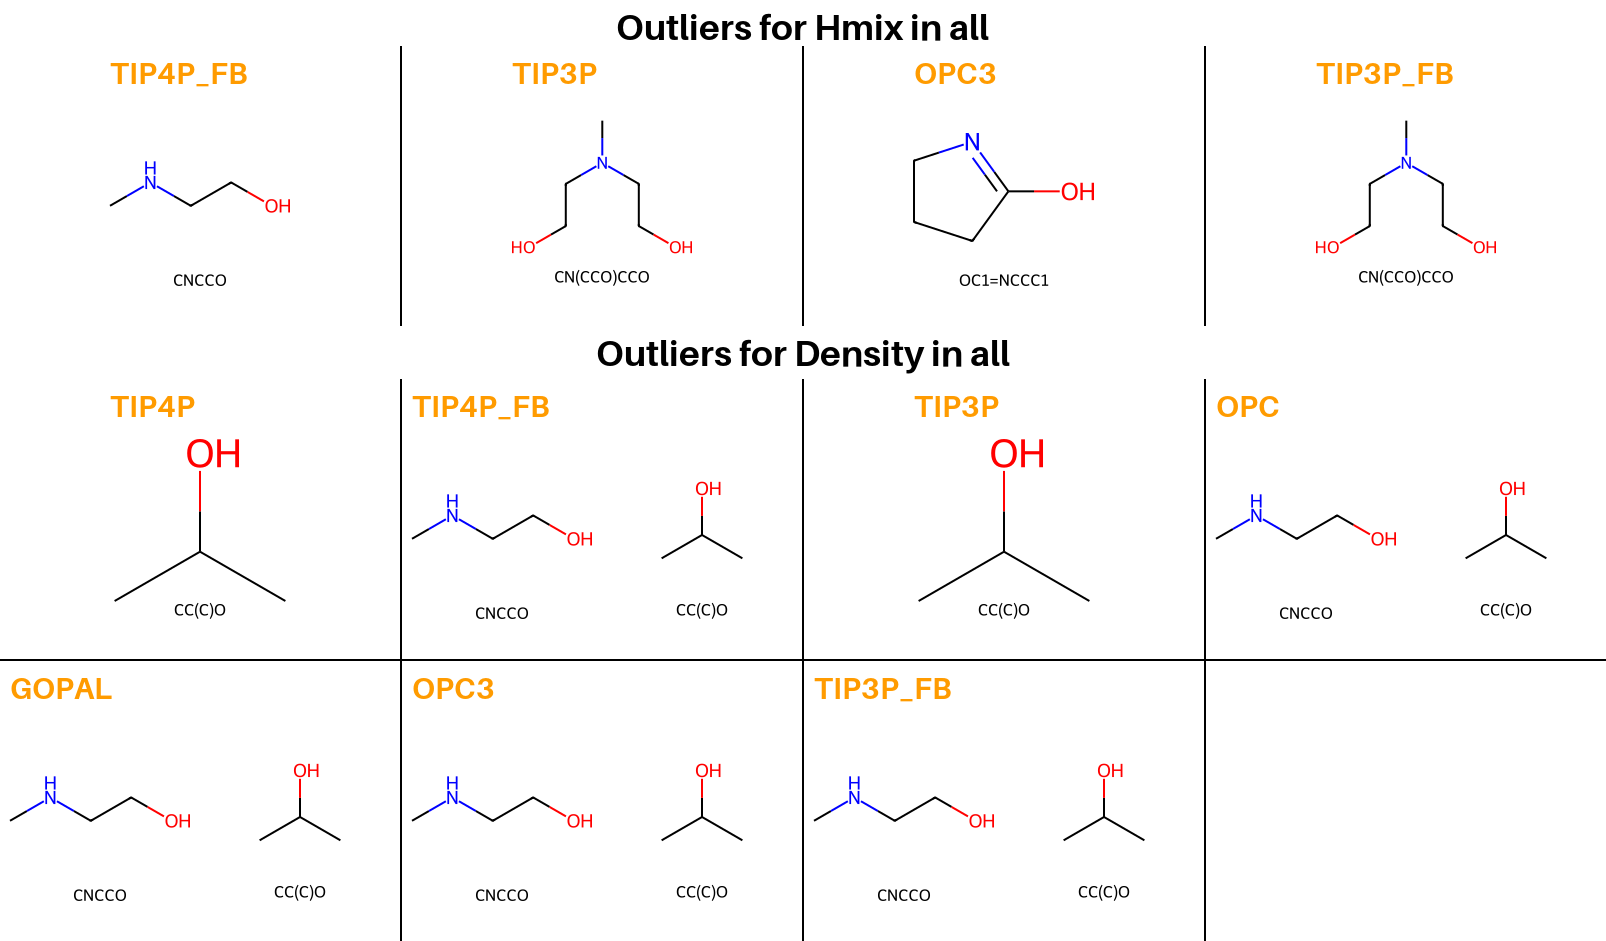

In [49]:
outlier_fig_list_path=os.path.abspath(os.getcwd())+'/outlier_figs/'
outlier_fig_list=[outlier_fig_list_path+'outliers_hmix_all.png',outlier_fig_list_path+'outliers_dens_all.png']
stack_figs_out(outlier_fig_list)

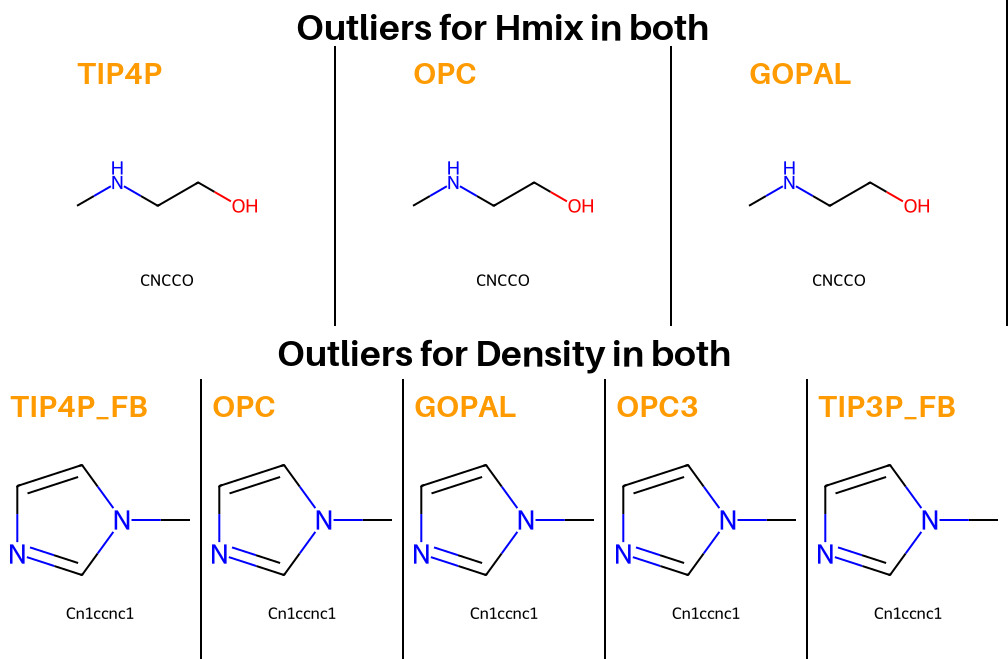

In [50]:
outlier_fig_list_path=os.path.abspath(os.getcwd())+'/outlier_figs/'
outlier_fig_list=[outlier_fig_list_path+'outliers_hmix_both.png',outlier_fig_list_path+'outliers_dens_both.png']
stack_figs_out(outlier_fig_list)